<a href="https://colab.research.google.com/github/Alvira-Parveen/multimodal-fake-news-/blob/main/multimodal_fake_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# Step 1 – Setup (GPU + installs)

!nvidia-smi   # check if GPU is available
!pip install torch torchvision transformers tqdm scikit-learn pillow requests


Mon Sep 29 15:41:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P0             28W /   70W |     644MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [20]:
# Step 2 – Mount Google Drive & unzip dataset

from google.colab import drive
drive.mount('/content/drive')

import os, zipfile

ZIP_PATH = "/content/drive/MyDrive/Dataset/weibo.zip"
BASE_DIR = "/content/weibo"

if not os.path.exists(BASE_DIR):
    print("Unzipping dataset...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as z:
        z.extractall(BASE_DIR)
else:
    print("Already extracted:", BASE_DIR)

!ls /content/weibo | head -20


Mounted at /content/drive
Unzipping dataset...
Description
fake_news
real_news


In [21]:
# Step 3 – Parse JSON files into DataFrame

import json, pandas as pd

rows = []
for root, dirs, files in os.walk(BASE_DIR):
    for f in files:
        if f == "new.json":
            label = 1 if "fake_news" in root else (0 if "real_news" in root else None)
            if label is not None:
                try:
                    with open(os.path.join(root, f), "r", encoding="utf-8") as fh:
                        j = json.load(fh)
                    text = (j.get("text_raw") or j.get("text") or "").strip()
                    image_url = None
                    pic_infos = j.get("pic_infos", {})
                    if isinstance(pic_infos, dict) and len(pic_infos) > 0:
                        first = list(pic_infos.values())[0]
                        for key in ("original","large","bmiddle","mw2000"):
                            if isinstance(first.get(key), dict) and "url" in first[key]:
                                image_url = first[key]["url"]; break
                    if text:
                        rows.append([text, image_url, label])
                except:
                    continue

df = pd.DataFrame(rows, columns=["text","image_url","label"])
print("✅ Parsed samples:", len(df))
print(df.head())
print(df["label"].value_counts())

CLEAN_CSV = os.path.join(BASE_DIR, "weibo_clean.csv")
df.to_csv(CLEAN_CSV, index=False)
print("Saved clean dataset to", CLEAN_CSV)


✅ Parsed samples: 11329
                                                text  \
0                                  流浪狗 流浪猫  流浪鸡… ​​​   
1  #官方回应玛莎拉蒂女司机醉驾找关系# 官方回应正在核查，老百姓其实更想知道，网传的这俩人，一...   
2                        #韩国民众在汉江拍到水怪#\n鉴定为挂住的塑料 ​​​   
3                               我要去 我现在就收拾行李 拜拜了 ​​​   
4  #黎巴嫩首都突发爆炸#当地时间4日，黎巴嫩首都发生爆炸，天空出现蘑菇云，死亡人数达到上千人。...   

                                           image_url  label  
0  https://wx3.sinaimg.cn/orj1080/006zt3X9gy1hdaz...      1  
1  https://wx1.sinaimg.cn/orj1080/6dbbb365ly1gw9a...      1  
2  https://wx2.sinaimg.cn/orj1080/006WjnFPly1h60m...      1  
3  https://wx3.sinaimg.cn/orj1080/008pOE3Mly1h8bo...      1  
4                                               None      1  
label
0    5668
1    5661
Name: count, dtype: int64
Saved clean dataset to /content/weibo/weibo_clean.csv


In [22]:
# Step 4 – Train / Test split

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=42
)

print("Train samples:", len(train_df))
print("Test samples:", len(test_df))


Train samples: 9063
Test samples: 2266


In [23]:
# Step 5 – Download images

import requests
from tqdm import tqdm

IMAGES_DIR = "/content/weibo_images"
os.makedirs(IMAGES_DIR, exist_ok=True)

session = requests.Session()
session.headers.update({"User-Agent": "Mozilla/5.0"})

def download_images(df, limit=None):
    downloaded = 0
    local_paths = []
    for i, row in tqdm(df.iterrows(), total=len(df)):
        url = row["image_url"]; local_path = None
        if isinstance(url, str) and url.strip():
            try:
                local_path = os.path.join(IMAGES_DIR, f"{i}.jpg")
                if not os.path.exists(local_path):
                    resp = session.get(url, timeout=8)
                    if resp.status_code == 200:
                        with open(local_path, "wb") as fh:
                            fh.write(resp.content)
                if os.path.exists(local_path): downloaded += 1
            except: local_path = None
        local_paths.append(local_path)
        if limit and downloaded >= limit: break
    print("Downloaded:", downloaded)
    return local_paths

train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

train_df["image"] = download_images(train_df, limit=2000)   # safe limit first run
test_df["image"]  = download_images(test_df, limit=500)

train_df.to_csv("/content/train_with_images.csv", index=False)
test_df.to_csv("/content/test_with_images.csv", index=False)
print("✅ Saved train/test datasets with local image paths")


100%|██████████| 9063/9063 [00:20<00:00, 452.04it/s]


Downloaded: 0


100%|██████████| 2266/2266 [00:04<00:00, 496.04it/s]

Downloaded: 0
✅ Saved train/test datasets with local image paths


In [25]:
# Step 6 – Dataset + DataLoader

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import BertTokenizer

BATCH_SIZE = 16
MAX_LEN = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", DEVICE)

tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")

image_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

class WeiboDataset(Dataset):
    def __init__(self, df, tokenizer, transform, max_length=64):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_length = max_length
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = str(row["text"])
        enc = self.tokenizer(text, padding="max_length", truncation=True,
                             max_length=self.max_length, return_tensors="pt")
        input_ids = enc["input_ids"].squeeze(0)
        attention_mask = enc["attention_mask"].squeeze(0)
        img_path = row.get("image")
        if isinstance(img_path, str) and os.path.exists(img_path):
            img = Image.open(img_path).convert("RGB"); image = self.transform(img)
        else:
            image = torch.zeros(3,224,224)
        label = int(row["label"])
        return {"input_ids": input_ids,"attention_mask": attention_mask,
                "image": image,"label": torch.tensor(label)}

train_df = pd.read_csv("/content/train_with_images.csv")
test_df  = pd.read_csv("/content/test_with_images.csv")

train_ds = WeiboDataset(train_df, tokenizer, image_transform, max_length=MAX_LEN)
test_ds  = WeiboDataset(test_df, tokenizer, image_transform, max_length=MAX_LEN)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

batch = next(iter(train_loader))
print("✅ Batch shapes:", batch["input_ids"].shape, batch["image"].shape, batch["label"].shape)


✅ Using device: cuda
✅ Batch shapes: torch.Size([16, 64]) torch.Size([16, 3, 224, 224]) torch.Size([16])


In [26]:
# Step 7 – Define Multimodal Model (BERT + ResNet50 Fusion)

import torch.nn as nn
from torchvision import models
from transformers import BertModel

class MultimodalFakeNewsModel(nn.Module):
    def __init__(self, text_model_name="bert-base-chinese", num_labels=2):
        super().__init__()
        # Text Encoder
        self.text_encoder = BertModel.from_pretrained(text_model_name)
        text_dim = self.text_encoder.config.hidden_size  # 768 for base BERT

        # Image Encoder (ResNet50 pretrained on ImageNet)
        resnet = models.resnet50(pretrained=True)
        resnet.fc = nn.Identity()   # remove final classifier
        self.image_encoder = resnet
        img_dim = 2048

        # Projection layers
        self.text_fc = nn.Linear(text_dim, 512)
        self.img_fc = nn.Linear(img_dim, 512)

        # Fusion classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 + 512, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_labels)
        )

    def forward(self, input_ids, attention_mask, images):
        # Text features
        txt_out = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        txt_feat = txt_out.pooler_output if txt_out.pooler_output is not None else txt_out.last_hidden_state[:,0,:]
        txt_feat = self.text_fc(txt_feat)

        # Image features
        img_feat = self.image_encoder(images)
        img_feat = self.img_fc(img_feat)

        # Fusion
        fused = torch.cat([txt_feat, img_feat], dim=1)
        logits = self.classifier(fused)
        return logits

# Init model
model = MultimodalFakeNewsModel().to(DEVICE)
print("✅ Model ready on:", DEVICE)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Model ready on: cuda


In [27]:
# Step 8 – Training & Evaluation Functions

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    losses, preds_all, labels_all = [], [], []
    for batch in tqdm(loader, desc="Train"):
        optimizer.zero_grad()
        ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        imgs = batch["image"].to(device)
        labels = batch["label"].to(device)

        logits = model(ids, mask, imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        preds = logits.argmax(dim=1).cpu().numpy()
        preds_all.extend(preds)
        labels_all.extend(labels.cpu().numpy())
    return np.mean(losses), accuracy_score(labels_all, preds_all), f1_score(labels_all, preds_all, average="macro")

def evaluate(model, loader, criterion, device):
    model.eval()
    losses, preds_all, labels_all = [], [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Eval"):
            ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            imgs = batch["image"].to(device)
            labels = batch["label"].to(device)

            logits = model(ids, mask, imgs)
            loss = criterion(logits, labels)
            losses.append(loss.item())

            preds = logits.argmax(dim=1).cpu().numpy()
            preds_all.extend(preds)
            labels_all.extend(labels.cpu().numpy())
    return np.mean(losses), accuracy_score(labels_all, preds_all), f1_score(labels_all, preds_all, average="macro")


In [36]:
# Step 9 – Training Loop

EPOCHS = 8   # keep small first, increase later
best_val_f1 = 0

for epoch in range(EPOCHS):
    train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_acc, val_f1 = evaluate(model, test_loader, criterion, DEVICE)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.3f}, F1: {train_f1:.3f} || "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.3f}, F1: {val_f1:.3f}")

    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_model.pt")
        print("✅ Saved new best model!")


Eval: 100%|██████████| 142/142 [00:16<00:00,  8.82it/s]


Epoch 1/8 | Train Loss: 0.0218, Acc: 0.991, F1: 0.991 || Val Loss: 0.2873, Acc: 0.929, F1: 0.929
✅ Saved new best model!


Eval: 100%|██████████| 142/142 [00:16<00:00,  8.76it/s]


Epoch 2/8 | Train Loss: 0.0128, Acc: 0.993, F1: 0.993 || Val Loss: 0.3506, Acc: 0.931, F1: 0.931
✅ Saved new best model!


Eval: 100%|██████████| 142/142 [00:16<00:00,  8.78it/s]


Epoch 3/8 | Train Loss: 0.0173, Acc: 0.992, F1: 0.992 || Val Loss: 0.3804, Acc: 0.927, F1: 0.927


Eval: 100%|██████████| 142/142 [00:16<00:00,  8.74it/s]


Epoch 4/8 | Train Loss: 0.0223, Acc: 0.990, F1: 0.990 || Val Loss: 0.3205, Acc: 0.923, F1: 0.923


Eval: 100%|██████████| 142/142 [00:16<00:00,  8.83it/s]


Epoch 5/8 | Train Loss: 0.0177, Acc: 0.992, F1: 0.992 || Val Loss: 0.3605, Acc: 0.920, F1: 0.920


Eval: 100%|██████████| 142/142 [00:16<00:00,  8.82it/s]


Epoch 6/8 | Train Loss: 0.0135, Acc: 0.993, F1: 0.993 || Val Loss: 0.3922, Acc: 0.930, F1: 0.930


Eval: 100%|██████████| 142/142 [00:16<00:00,  8.80it/s]


Epoch 7/8 | Train Loss: 0.0155, Acc: 0.992, F1: 0.992 || Val Loss: 0.4306, Acc: 0.924, F1: 0.924


Eval: 100%|██████████| 142/142 [00:16<00:00,  8.84it/s]


Epoch 8/8 | Train Loss: 0.0215, Acc: 0.992, F1: 0.992 || Val Loss: 0.3456, Acc: 0.931, F1: 0.931
✅ Saved new best model!


In [37]:
# Step 10 – Inference Helper

def infer(text, image_path=None):
    model.eval()
    enc = tokenizer(text, padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt")
    ids, mask = enc["input_ids"].to(DEVICE), enc["attention_mask"].to(DEVICE)

    if image_path and os.path.exists(image_path):
        img = Image.open(image_path).convert("RGB")
        img_tensor = image_transform(img).unsqueeze(0).to(DEVICE)
    else:
        img_tensor = torch.zeros(1,3,224,224).to(DEVICE)

    with torch.no_grad():
        logits = model(ids, mask, img_tensor)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        pred = int(np.argmax(probs))
    return pred, probs

# Test on one sample
sample = test_df.sample(1).iloc[0]
pred, probs = infer(sample["text"], sample["image"] if pd.notna(sample["image"]) else None)
print("True:", sample["label"], "| Pred:", pred, "| Probs:", probs)


True: 1 | Pred: 1 | Probs: [1.0192944e-04 9.9989808e-01]


📊 Classification Report:
               precision    recall  f1-score   support

           0     0.9453    0.9145    0.9296      1134
           1     0.9170    0.9470    0.9318      1132

    accuracy                         0.9307      2266
   macro avg     0.9312    0.9307    0.9307      2266
weighted avg     0.9312    0.9307    0.9307      2266



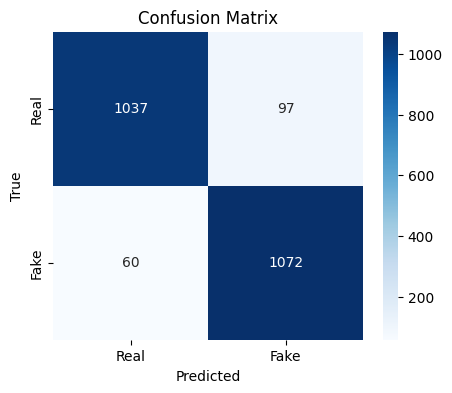

In [38]:
# Confusion Matrix & Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 🔹 Evaluate on test set
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        ids = batch["input_ids"].to(DEVICE)
        mask = batch["attention_mask"].to(DEVICE)
        imgs = batch["image"].to(DEVICE)
        labels = batch["label"].to(DEVICE)

        logits = model(ids, mask, imgs)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Classification report
print("📊 Classification Report:\n", classification_report(all_labels, all_preds, digits=4))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Fake"],
            yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
